In [2]:
import pandas as pd
import chordparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

---------------

### Definitions

In [3]:
cp = chordparser.Parser()
CE = chordparser.ChordEditor()
CRC = chordparser.ChordRomanConverter()

In [4]:
sharps_to_flats = {
    'C#': 'Db',
    'D#': 'Eb',
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
}

In [5]:
lower_base = {
    'C': 'B',
    'B': 'Bb',
    'Bb': 'A',
    'A': 'Ab',
    'Ab': 'G',
    'G': 'Gb',
    'Gb': 'F',
    'F': 'E',
    'E': 'Eb',
    'Eb': 'D',
    'D': 'Db',
    'Db': 'C'
}

In [6]:
number_of_songs = {'Country': 0,
                   'Electronic': 0,
                   'Pop': 0,
                   'Rock': 0}

In [7]:
# {'Country': {'IV': 30, 'V': 2, ...}, 'Pop': {...}, ...}
nodelists_sum = {'Country': {},
                 'Electronic': {},
                 'Pop': {},
                 'Rock': {}}

In [8]:
dataframes = {'Country': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Electronic': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Pop': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Rock': pd.DataFrame(columns=['from_roman', 'to_roman'])}

In [9]:
nodelists = {}

----------------------

### Single song processing

In [10]:
def get_roman_dataframe(file):
    # dataframe
    df = pd.read_csv(file, delimiter='\t', skiprows=2, header=None)
    df.columns=['from', 'to']

    # signature
    with open(file, "r") as fin:
        signature = fin.readlines()[:2]
        
    base = re.split(':|\\n', signature[0])[1]
    capo = re.split(':|\\n', signature[1])[1]
    
    if capo == 'None':
        capo = 0
    else:
        capo = int(capo)

    # key and scale
    if('m' in base):
        mode = 'minor'
        base = base.replace('m', '')
    else:
        mode = 'major'
        
    if base in sharps_to_flats.keys() and base != df['from'][0].replace('m', ''):
        base = sharps_to_flats[base]  

    for i in range(capo):
        base = lower_base[base]
    
    key = cp.create_key(base, mode)

    df['from'] = df['from'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))
    df['to'] = df['to'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))

    # convert to roman
    if base in sharps_to_flats.keys():
        base = sharps_to_flats[base]  
        
    df['from_roman'] = df['from'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    df['to_roman'] = df['to'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    
    df = df.drop(columns=['from','to'])

    return df

In [11]:
def add_to_nodelist(df, genre):    
    all_chords = pd.unique(df.values.ravel('K'))
    
    dataframes[genre] = dataframes[genre].append(df)
        
    for chord in all_chords:
        value_count = 0
        
        if chord in df.from_roman.values:
            value_count = df.from_roman.value_counts()[chord]

        # include last chord
        if (df.to_roman.iloc[-1]) == chord:
            value_count += 1

        # add appearances to nodelist
        if chord not in nodelists_sum[genre].keys():
            nodelists_sum[genre][chord] = 0
        nodelists_sum[genre][chord] += value_count

    return

In [12]:
def process_song(file):

    df = get_roman_dataframe(file)
    
    genre = file.split('/')[1]
    add_to_nodelist(df, genre)

    number_of_songs[genre] += 1

### Genre processing

In [13]:
def create_nodelist(genre):
    df = pd.DataFrame([nodelists_sum[genre]])
    df = df.T.rename(columns={0: 'sum_appearance'})
    
    df['percent'] = df['sum_appearance'] / df['sum_appearance'].sum()
    df['average_appearance'] = df['sum_appearance'] / number_of_songs[genre]

    df = df.reset_index()
    df = df.rename(columns={'index': 'Id'})
    
    return df

In [14]:
def get_percentages(df, nodelist):

    df = df.groupby(df.columns.tolist(),as_index=False).size()
    df['percent'] = df['size'] / df['size'].sum()
    
    df = df.rename(columns={'size': 'sum_appearance', 'from_roman': 'Source', 'to_roman': 'Target'})

    log_ratio = []
    for i, row in df.iterrows():
        source_percent = nodelist.loc[nodelist['Id'] == row.Source, 'percent'].iloc[0]
        target_percent = nodelist.loc[nodelist['Id'] == row.Target, 'percent'].iloc[0]
        log_ratio.append(np.log(row.percent / (source_percent * target_percent)))

    df['log_ratio'] = log_ratio

    return df

--------------

## Main

### Process every song

In [15]:
directory = 'data/'

for subdir, dirs, files in os.walk(directory):
    for i, filename in enumerate(os.listdir(subdir)):
        f = os.path.join(subdir, filename)
        if os.path.isfile(f):
            df = process_song(f)

### Process genres

In [16]:
for genre, df in dataframes.items():
    nodelists[genre] = create_nodelist(genre)
    dataframes[genre] = get_percentages(df, nodelists[genre])

### Co-occurence Matrix

In [23]:
coocc = {}

In [31]:
import networkx

for genre, df in dataframes.items():
    edgeList = df[['Source', 'Target', 'sum_appearance']].values.tolist()
    G = networkx.DiGraph()
    for i in range(len(edgeList)):
        G.add_edge(edgeList[i][0], edgeList[i][1], weight=edgeList[i][2])

    coocc[genre] = networkx.to_pandas_adjacency(G, nodelist=nodelists_sum[genre].keys())

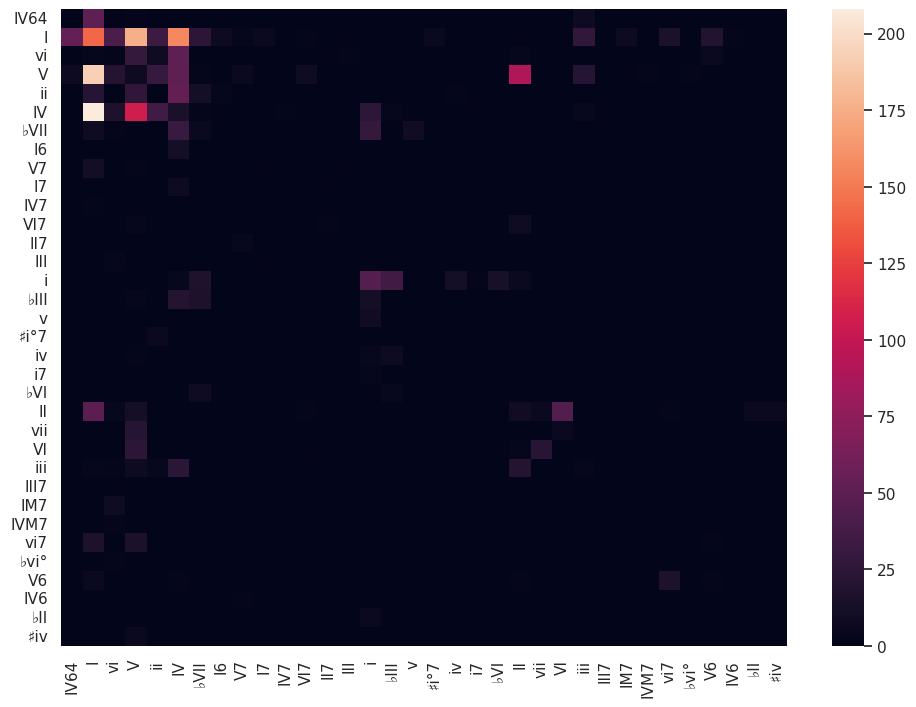

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
_ = sns.heatmap(coocc['Country'])

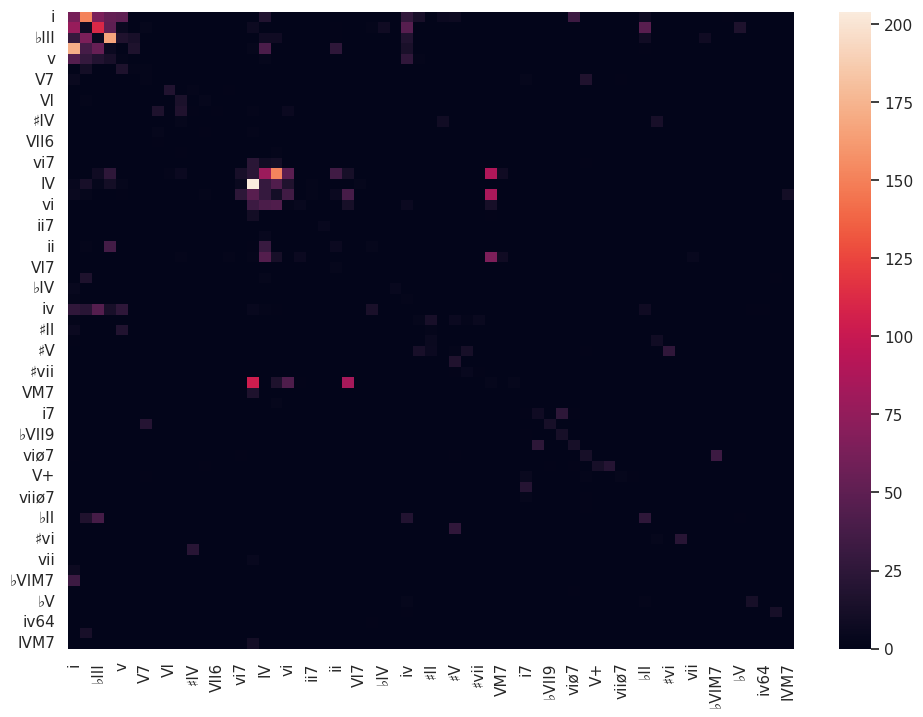

In [39]:
_ = sns.heatmap(coocc['Electronic'])

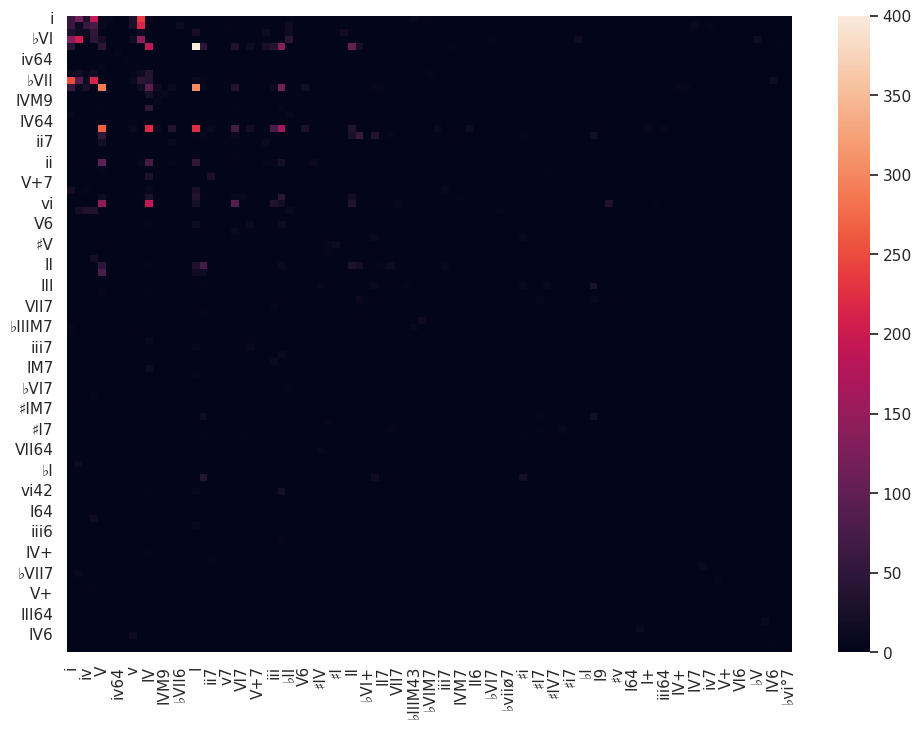

In [40]:
_ = sns.heatmap(coocc['Pop'])

Get only values that have at least one co-occurence of > 100

In [129]:
above_100_mask = (coocc['Rock'] > 100).any()
rock_100 = coocc['Rock'][above_100_mask][list(above_100_mask[above_100_mask == True].index)]

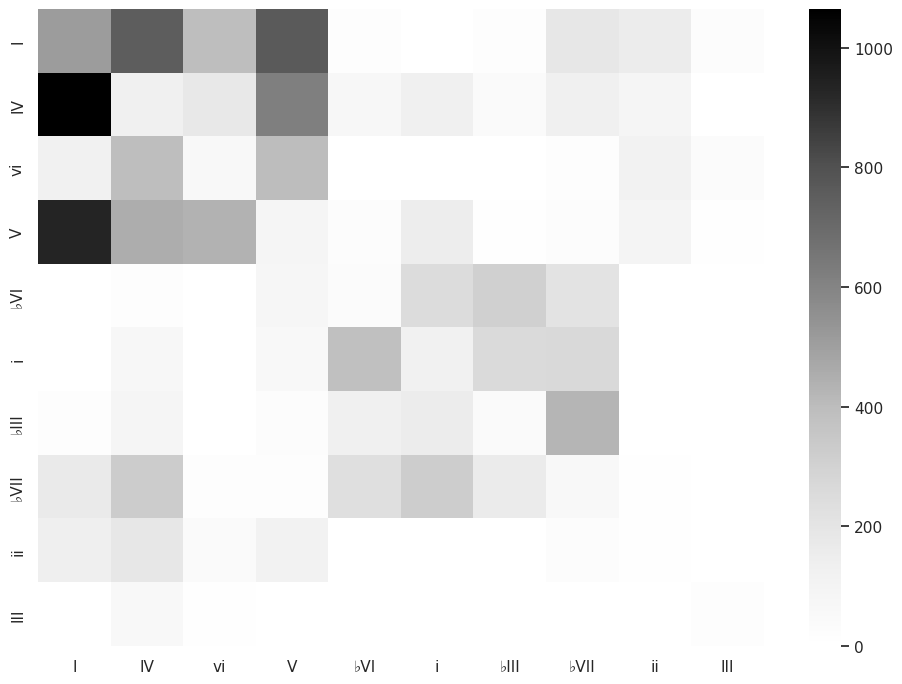

In [111]:
# sns.color_palette("deep")
_ = sns.heatmap(rock_100, cmap='Greys')

### Save nodelists and edgelists

In [18]:
for genre, df in dataframes.items():
    df.to_csv('edge_lists/edges_' + genre.lower() + '.csv', index=False)
    nodelists[genre].to_csv('node_lists/nodes_' + genre.lower() + '.csv', index=False)

In [128]:
dataframes['Rock']

,Source,Target,sum_appearance,percent,log_ratio
0,I,I,514,0.024046,-0.139830
1,I,I64,16,0.000749,1.021095
2,I,I7,19,0.000889,0.378845
3,I,I9,4,0.000187,1.803854
4,I,II,75,0.003509,0.095476
...,...,...,...,...,...
862,♯v,♯i,1,0.000047,2.981257
863,♯v°,I,1,0.000047,-0.393370
864,♯v°,v7,1,0.000047,4.296030
865,♯v°,vi,7,0.000327,2.513694


In [20]:
nodelists['Country']

,Id,sum_appearance,percent,average_appearance
0,IV64,62,0.023592,2.066667
1,I,736,0.280061,24.533333
2,vi,104,0.039574,3.466667
3,V,442,0.168189,14.733333
4,ii,116,0.044140,3.866667
5,IV,423,0.160959,14.100000
6,♭VII,86,0.032725,2.866667
7,I6,11,0.004186,0.366667
8,V7,15,0.005708,0.500000
9,I7,8,0.003044,0.266667


# Smol EDA

In [104]:
df_number_of_songs = pd.DataFrame(number_of_songs, index=number_of_songs.keys())

In [130]:
enmax_palette = ["#31394d"]
sns.set_palette(palette=enmax_palette)

<AxesSubplot: >

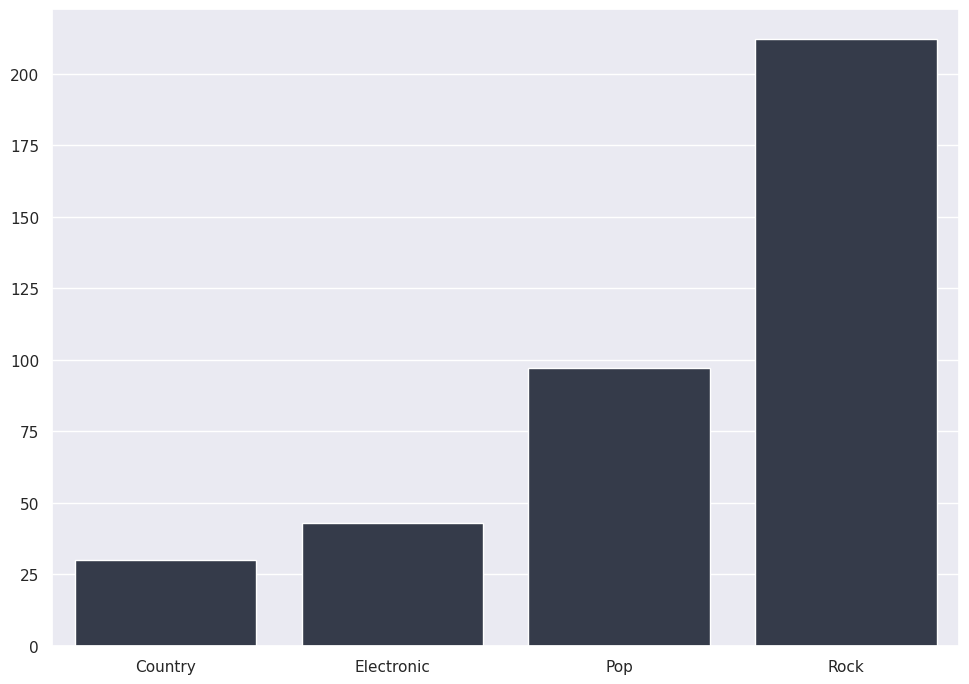

In [131]:
sns.barplot(df_number_of_songs, color='C0')

# Todo

- X heatmap of matrix
- graphs for genres
- size of edges (how often does it appear/how probable)
- more pruning (threshold for edges/nodes)